## NoSQL (MongoDB) (sesión 2), 25-26.

## Introducción

![MongoDB](https://webassets.mongodb.com/_com_assets/cms/MongoDB_Logo_FullColorBlack_RGB-4td3yuxzjs.png)

Esta hoja muestra cómo acceder a bases de datos MongoDB y también a conectar la salida con Jupyter. Se puede utilizar el *shell* propio de MongoDB en el contenedor usando el programa `mongo`. La diferencia es que ese programa espera código Javascript y aquí trabajaremos con Python.

In [1]:
import sys

RunningInCOLAB: bool = 'google.colab' in sys.modules

## Instalación inicial de MongoDB (sólo necesaria en Google Colab)

In [2]:
import subprocess
import urllib.request

if RunningInCOLAB:
  urllib.request.urlretrieve("https://raw.githubusercontent.com/dsevilla/bdge/refs/heads/25-26/addendum/mongo-utils/run-mongo-local.sh",
                             "run-mongo-local.sh")
  subprocess.run(["sh", "run-mongo-local.sh"])

## Instalación de la librería `pymongo`

In [3]:
%pip install --upgrade pymongo 'pandas[performance,parquet]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 87.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 3.0.1 which is incompatible.
db-dtypes 1.5.0 requires pandas<3.0.0,>=1.5.3, but you have pandas 3.0.1 which is incompatible.
bqplot 0.12.45 requires pandas<3.0.0,>=1.0.0, but you have pandas 3.0.1 which is incompatible.
gradio 5.50.0 requires pandas<3.0,>=1.0, but you have pandas 3.0.1 which 

In [4]:
from pprint import pprint as pp

import pandas as pd

Usaremos la librería `pymongo` para python. La cargamos a continuación.

In [5]:
from pymongo import MongoClient

## Conexión a la base de datos

La conexión se inicia con `MongoClient` en el `host` descrito en el fichero `docker-compose.yml` (establecido en la variable de entorno `DB_HOSTNAME`), o bien a `localhost` si lo estamos haciendo en Colab.

In [6]:
import os

db_hostname: str = os.getenv('DB_HOSTNAME', "localhost")

In [7]:
from typing import Any

client: MongoClient[dict[str, Any]] = MongoClient(db_hostname,27017,compressors='zlib')
client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True, compressors=['zlib'])

In [8]:
client.list_database_names()

['admin', 'config', 'local']

Las bases de datos se crean conforme se nombran. Se puede utilizar la notación punto o la de diccionario. Las colecciones también se crean implícitamente al insertar un primer documento, o las podemos crear explícitamente.

In [9]:
from pymongo.collection import Collection
from pymongo.database import Database

db: Database = client.stackoverflow
# db: Database = client['stackoverflow'] # (equivalente)
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True, compressors=['zlib']), 'stackoverflow')

## Importación de los datos de Stackoverflow

Procedemos a importar los ficheros Parquet, pero antes ponemos el formato y signifcado de los campos de `Stack Overflow` para poder consultarlos si lo necesitamos.

<details><summary><b>🗂️ Formato datos Stack Overflow</b> <span style="color: #007acc;">▶️ Haz click para ver el esquema y ejemplos</span></summary>

> Notas generales
- Formato: cada fichero es XML y suele distribuirse 7zipped.
- Codificación: UTF-8. Los campos de fecha siguen el formato ISO8601: "YYYY-MM-DDTHH:mm:ss.fff".
- Nulos: cuando un campo no aplica (p.ej., `ParentId` en preguntas), no aparece o viene vacío; en nuestros Parquet suele ser `null`.
- Identificadores: `Id` es clave primaria en cada entidad. Claves foráneas enlazan por `Id` entre ficheros.

---

:file_folder: <b>badges.xml</b> (insignias logradas por usuarios)
- UserId: Id del usuario que recibe la insignia. Ej: 420. Uso: FK a `users.Id`.
- Name: Nombre de la insignia. Ej: "Teacher". Uso: clasificar tipo de logro.
- Date: Fecha de concesión. Ej: "2008-09-15T08:55:03.923". Uso: series temporales.
- Class: Categoría (1=Gold, 2=Silver, 3=Bronze). Ej: 3. Uso: nivel de la insignia.
- TagBased: Si la insignia es específica de etiqueta. Ej: true. Uso: filtrar logros por etiquetas.

---

:file_folder: <b>comments.xml</b> (comentarios en publicaciones)
- Id: Identificador del comentario. Ej: 12345. Uso: PK.
- PostId: Publicación a la que comenta. Ej: 100234. Uso: FK a `posts.Id`.
- Score: Puntuación del comentario. Ej: 5. Uso: ordenar/filtrar relevancia.
- Text: Texto del comentario. Ej: "¿Puedes compartir el error exacto?". Uso: contenido.
- CreationDate: Fecha de creación. Ej: "2008-09-06T08:07:10.730". Uso: análisis temporal.
- UserId: Autor del comentario. Ej: 314159. Uso: FK a `users.Id`.
- UserDisplayName: Nombre mostrado si el usuario fue eliminado. Ej: "user123". Uso: se usa cuando `UserId` es nulo/ausente.
- ContentLicense: Licencia del contenido. Ej: "CC BY-SA 4.0". Uso: cumplimiento/licencias.

---

:file_folder: <b>posts.xml</b> (preguntas y respuestas)
- Id: Identificador de la publicación. Ej: 98765. Uso: PK.
- PostTypeId: Tipo (1=Pregunta, 2=Respuesta). Ej: 1. Uso: rutas de procesamiento/particionado.
- ParentId: Id de la pregunta padre si es respuesta. Ej: 1234. Uso: FK a `posts.Id` (solo si `PostTypeId=2`).
- AcceptedAnswerId: Id de la respuesta aceptada (solo en preguntas). Ej: 4567. Uso: FK a `posts.Id` para marcar aceptadas.
- CreationDate: Fecha de creación. Ej: "2010-02-15T10:21:34.120". Uso: análisis temporal.
- Score: Votos netos (upvotes-downvotes). Ej: 42. Uso: ranking/calidad.
- ViewCount: Nº de vistas (solo preguntas). Ej: 12345. Uso: popularidad.
- Body: HTML/Markdown del cuerpo. Ej: "<p>¿Cómo...?</p>". Uso: contenido/NLP.
- OwnerUserId: Autor. Ej: 271828. Uso: FK a `users.Id`.
- OwnerDisplayName: Nombre mostrado si el autor fue eliminado. Ej: "John Doe". Uso: se usa cuando `OwnerUserId` es nulo (usuario eliminado o anónimo).
- LastEditorUserId: Último usuario que editó. Ej: 314159. Uso: FK a `users.Id`.
- LastEditorDisplayName: Nombre si el editor fue eliminado. Ej: "Community". Uso: solo cuando `LastEditorUserId` es nulo.
- LastEditDate: Fecha de última edición. Ej: "2009-03-05T22:28:34.823". Uso: auditoría.
- LastActivityDate: Última actividad (edición, comentario, etc.). Ej: "2009-03-11T12:51:01.480". Uso: ordenación por actividad reciente.
- CommunityOwnedDate: Fecha desde la que es de la comunidad. Ej: "2009-03-11T12:51:01.480". Uso: gobernanza.
- ClosedDate: Fecha de cierre (si procede). Ej: "2012-01-01T12:00:00.000". Uso: moderación.
- Title: Título de la pregunta. Ej: "¿Cómo unir listas en Python?". Uso: metadata/búsqueda.
- Tags: Lista de etiquetas en formato XML/HTML: "<python><list><merge>". Uso: clasificación por tema.
- AnswerCount: Nº de respuestas (en preguntas). Ej: 5. Uso: engagement.
- CommentCount: Nº de comentarios. Ej: 3. Uso: actividad.
- FavoriteCount: Favoritos marcados (legacy). Ej: 10. Uso: popularidad histórica.
- ContentLicense: Licencia. Ej: "CC BY-SA 4.0". Uso: cumplimiento.

---

:file_folder: <b>posthistory.xml</b> (historial detallado de cambios)
- Id: PK del evento de historial. Ej: 5555.
- PostHistoryTypeId: Tipo de cambio. Uso: clasifica el evento. Ejemplos:
  - 1: Initial Title – primer título de la pregunta.
  - 2: Initial Body – primer cuerpo en crudo.
  - 3: Initial Tags – primeras etiquetas.
  - 4: Edit Title – cambio de título.
  - 5: Edit Body – cambio de cuerpo (markdown crudo).
  - 6: Edit Tags – cambio de etiquetas.
  - 7/8/9: Rollback Title/Body/Tags – revertidos.
  - 10: Post Closed – cierre por votos.
  - 11: Post Reopened – reapertura.
  - 12/13: Post Deleted/Undeleted – borrado/restaurado.
  - 14/15: Post Locked/Unlocked – bloqueado/desbloqueado.
  - 16: Community Owned – pasa a comunidad.
  - 17: Post Migrated – migración (origen/destino).
  - 18: Question Merged – fusión de preguntas.
  - 19/20: Question Protected/Unprotected – protegido/desprotegido.
  - 21: Post Disassociated – se elimina el OwnerUserId.
  - 22: Question Unmerged – deshace fusión.
- PostId: Publicación afectada. Ej: 98765. Uso: FK a `posts.Id`.
- RevisionGUID: Agrupa múltiples registros de un mismo acto. Ej: "3E5B...". Uso: correlación.
- CreationDate: Fecha del evento. Ej: "2009-03-05T22:28:34.823".
- UserId: Usuario que realiza el cambio. Ej: 271828. Uso: FK a `users.Id`.
- UserDisplayName: Si el usuario fue eliminado. Ej: "user123". Uso: cuando `UserId` nulo.
- Comment: Comentario del editor. Ej: "typo fix". Uso: auditoría.
- Text: Valor crudo nuevo asociado al cambio. Ej: nuevo markdown o JSON.
  - Para tipos 10–15: JSON con usuarios que han votado esa acción de moderación.
  - Para tipo 17: Detalles de migración: "from <url>" o "to <url>".
- CloseReasonId: Motivo de cierre (histórico). Ejemplos:
  - 1: Exact Duplicate – duplicada de otra.
  - 2: off-topic – fuera de tema.
  - 3: subjective – demasiado subjetiva.
  - 4: not a real question – no es una pregunta real.
  - 7: too localized – demasiado localizada.

---

:file_folder: <b>postlinks.xml</b> (enlaces entre publicaciones)
- Id: PK del enlace. Ej: 2222.
- CreationDate: Fecha del enlace. Ej: "2011-05-05T10:00:00.000".
- PostId: Publicación origen. Ej: 1000. Uso: FK a `posts.Id`.
- RelatedPostId: Publicación destino. Ej: 1001. Uso: FK a `posts.Id`.
- PostLinkTypeId: Tipo de relación. Uso: grafo entre posts.
  - 1: Linked – relacionados.
  - 3: Duplicate – duplicados.

---

:file_folder: <b>users.xml</b> (usuarios)
- Id: PK del usuario. Ej: 271828.
- AccountId: Id de cuenta en la red Stack Exchange. Ej: 123456. Uso: consolidación multi-sitio.
- Reputation: Reputación. Ej: 15234. Uso: privilegios/ordenación.
- CreationDate: Alta del usuario. Ej: "2008-07-31T21:42:52.667".
- DisplayName: Nombre mostrado. Ej: "Jane Doe". Uso: UI.
- EmailHash: Hash MD5 de email (legacy). Ej: "fcea920f...". Uso: avatar histórico.
- LastAccessDate: Último acceso. Ej: "2020-04-01T12:00:00.000". Uso: actividad.
- WebsiteUrl: Web personal. Ej: "https://janedoe.dev".
- Location: Ubicación libre. Ej: "Madrid, ES".
- Age: Edad (cuando se compartía). Ej: 32.
- AboutMe: BIO en HTML/Markdown. Ej: "<p>Desarrollo datos...</p>".
- Views: Visitas al perfil. Ej: 1234.
- UpVotes: Upvotes emitidos por el usuario. Ej: 500.
- DownVotes: Downvotes emitidos. Ej: 20.
- ProfileImageUrl: Avatar. Ej: "https://.../image.png".

---

:file_folder: <b>votes.xml</b> (votos a publicaciones)
- Id: PK del voto. Ej: 7777.
- PostId: Publicación votada. Ej: 98765. Uso: FK a `posts.Id`.
- VoteTypeId: Tipo de voto/acción. Uso: métricas de calidad/moderación.
  - 1: AcceptedByOriginator – el autor de la pregunta acepta una respuesta (equivale a `AcceptedAnswerId`).
  - 2: UpMod – upvote.
  - 3: DownMod – downvote.
  - 4: Offensive – ofensivo (legacy).
  - 5: Favorite – marcado como favorito (legacy); si `VoteTypeId=5`, `UserId` se rellena.
  - 6: Close – voto de cierre.
  - 7: Reopen – voto de reapertura.
  - 8: BountyStart – inicio de recompensa.
  - 9: BountyClose – cierre de recompensa; si `VoteTypeId=9`, `BountyAmount` se rellena.
  - 10: Deletion – voto de borrado.
  - 11: Undeletion – voto de restauración.
  - 12: Spam – marcado como spam.
  - 13: InformModerator – informar a moderación.
- CreationDate: Fecha del voto. Ej: "2015-06-10T09:30:00.000".
- UserId: Usuario que vota (solo para algunos tipos como 5). Ej: 54321. Uso: FK a `users.Id`.
- BountyAmount: Cantidad de recompensa (solo tipo 9). Ej: 100.

---

:file_folder: <b>tags.xml</b> (etiquetas del sitio)
- Id: PK de la etiqueta. Ej: 42.
- TagName: Nombre de la etiqueta. Ej: "python". Uso: clasificación temática.
- Count: Nº de usos en preguntas. Ej: 150234. Uso: popularidad.
- ExcerptPostId: Id del post con el extracto de la wiki de etiqueta. Ej: 123. Uso: FK a `posts.Id`.
- WikiPostId: Id del post con el artículo de la wiki de etiqueta. Ej: 124. Uso: FK a `posts.Id`.

</details>

Importamos los ficheros Parquet, primero definiendo las funciones que se necesitan, y después ejecutándolas.

In [10]:
from asyncio import Queue, Task, create_task, to_thread

from pandas import DataFrame


def load_dataframe(parquetfile: str, logqueue: Queue[str] | None = None) -> DataFrame:
    BASE_URL: str = "https://github.com/dsevilla/bd2-data/releases/download/parquet-files-25-26/"
    try:
        df: DataFrame = pd.read_parquet(f"{BASE_URL}/{parquetfile}", dtype_backend="pyarrow")
        logqueue.put_nowait(f"Loaded {len(df)} rows from dataframe.") if logqueue else None

        return df

    except Exception as e:
        logqueue.put_nowait(f"Error loading Dataframe: {e}.") if logqueue else None
        raise e

In [11]:
from pymongo.results import InsertManyResult


def insert_dataframe_into_mongo(
    collection: Collection, df: DataFrame, logqueue: Queue | None = None
) -> InsertManyResult:
    result: InsertManyResult = collection.insert_many(
        df.to_dict("records"), ordered=False, bypass_document_validation=True
    )
    logqueue.put_nowait(f"Inserted {len(df)} records into MongoDB.") if logqueue else None
    return result


def load_parquet_into_mongo(
    collection: Collection,
    parquetfile: str,
    logqueue: Queue[str] | None = None,
) -> InsertManyResult:
    df: DataFrame = load_dataframe(parquetfile, logqueue)
    try:
        return insert_dataframe_into_mongo(collection, df, logqueue)
    except Exception as e:
        logqueue.put_nowait(f"Error inserting DataFrame into MongoDB: {e}.") if logqueue else None
        raise e
    finally:
        del df  # Free memory

Importación de los ficheros Parquet. Por ahora creamos una colección diferente para cada uno. Después estudiaremos cómo poder optimizar el acceso usando agregación.

Creamos un índice para el campo 'Id' en la colección de tags.

In [12]:
tags_collection: Collection[dict[str, Any]] = db["tags"]
tags_collection.create_index([("Id", 1)], unique=True)

'Id_1'

Se crea una cola de mensajes (`Queue`) para que los procesos en segundo plano puedan ir mostrando el progreso de la importación. En cualquier momento se puede leer mensajes de esa cola (si están disponibles) y podemos ver si se ha producido algún error o si se ha terminado de procesar los elementos.

La importación de los *Tags* se realiza en primer plano porque es pequeña. El resto de colecciones las importaremos en segundo plano (con un hilo o *thread*).

In [13]:
# No añadir datos si ya existe la colección
existing_tags_count: int = tags_collection.count_documents({})
if existing_tags_count > 0:
    print("La colección Tags ya existe. No se realiza la importación. Elimínala con drop().")
else:
    insert_tags_queue: Queue[str] = Queue()
    load_parquet_into_mongo(tags_collection, "Tags.parquet", insert_tags_queue)
    while not insert_tags_queue.empty():
        log_message: str = await insert_tags_queue.get()
        print(log_message)

Loaded 3048 rows from dataframe.
Inserted 3048 records into MongoDB.


In [14]:
tags_collection.find_one()

{'_id': ObjectId('69a01e36117b25c802b113b4'),
 'Id': 1,
 'Count': 1472,
 'ExcerptPostId': 680,
 'TagName': '.net',
 'WikiPostId': 679}

Importamos los datos de Stackoverflow. Lo haremos en paralelo con todas las colecciones restantes:

In [15]:
users_collection: Collection[dict[str, Any]] = db["users"]
users_collection.create_index([("Id", 1)], unique=True)

users_load_task: Task[InsertManyResult] = create_task(
    to_thread(load_parquet_into_mongo, users_collection, "Users.parquet")
)

In [16]:
posts_collection: Collection[dict[str, Any]] = db["posts"]
posts_collection.create_index([("Id", 1)], unique=True)

posts_load_queue: Queue[str] = Queue()
posts_load_task: Task[InsertManyResult] = create_task(
    to_thread(load_parquet_into_mongo, posts_collection, "Posts.parquet", posts_load_queue)
)

In [17]:
comments_collection: Collection[dict[str, Any]] = db["comments"]
comments_collection.create_index([("Id", 1)], unique=True)

comments_load_queue: Queue[str] = Queue()
comments_load_task: Task[InsertManyResult] = create_task(
    to_thread(load_parquet_into_mongo, comments_collection, "Comments.parquet", comments_load_queue)
)

In [18]:
votes_collection: Collection[dict[str, Any]] = db["votes"]
votes_collection.create_index([("Id", 1)], unique=True)

votes_load_queue: Queue[str] = Queue()
votes_load_task: Task[InsertManyResult] = create_task(
    to_thread(load_parquet_into_mongo, votes_collection, "Votes.parquet", votes_load_queue)
)

In [19]:
print(f"Post loading done: {posts_load_task.done()}.")
while not posts_load_queue.empty():
    log_message: str = posts_load_queue.get_nowait()
    print(log_message)

Post loading done: False.


In [20]:
users_load_task.done()

False

In [21]:
comments_load_task.done()

False

In [22]:
votes_load_task.done()

False

## Framework de Agregación

Framework de agregación:
- Aquí está la referencia de las diferentes etapas por las que puede pasar un pipeline: https://www.mongodb.com/docs/manual/reference/operator/aggregation-pipeline/.
- Y aquí los distintos operadores que se permiten dentro de las etapas: https://docs.mongodb.com/manual/reference/operator/aggregation/.
- Y aquí incluso un libro completo con usos prácticos de ejecutar agregación: https://www.practical-mongodb-aggregations.com/.

A continuación un vídeo interesante:

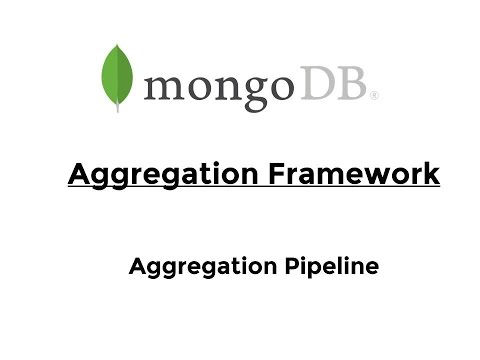

In [23]:
from IPython.display import YouTubeVideo

YouTubeVideo('VSX4a3h4SmQ',width=800)

Aquí tenemos un esquema con un ejemplo básico de agregación.

![](https://miro.medium.com/max/1060/1*2lDBxvZ8Cr3JYkoODTa0lQ.png)

## Esperamos a que todo se haya cargado para poder continuar.

In [24]:
import asyncio

await asyncio.gather(
    users_load_task,
    posts_load_task,
    comments_load_task,
    votes_load_task
);

## Algunos operadores de agregación

### `$match`

Este operador permite filtrar los documentos que queremos que pasen a la siguiente fase del pipeline definiendo una serie de condiciones sobre los campos de los documentos.

Vamos a filtrar aquellos documentos que tengan un `Score` igual o superior (`$gte`) a 150.

In [25]:
from pymongo.command_cursor import CommandCursor

respuestas: CommandCursor[dict[str, Any]] = db.posts.aggregate( [
        {'$match': { 'Score' : {'$gte': 150}}}
])
pp(list(respuestas))

[{'AcceptedAnswerId': None,
  'AnswerCount': 0,
  'Body': '<p>Asumiendo que se está haciendo un <code>join</code> de columnas '
          'sin duplicados, lo cuál es un caso '
          'común:</p><br/><ul><br/><li><p>Un <strong>inner join</strong> de A '
          'y B entregará el resultado de la intersección de los conjuntos A y '
          'B. En otras palabras, la parte <em>interna</em> –intersección– en '
          'un diagrama de Venn.</p><br/></li><br/><li><p>Un <strong>full outer '
          'join</strong> entre A y B entregará el resultado de la unión de A y '
          'B. En otras palabras, la parte <em>externa</em> –unión– en un '
          'diagrama de Venn '
          '.</p><br/></li><br/></ul><br/><h1>Ejemplos:</h1><br/><p>Supongamos '
          'que tenemos dos tablas, con una sola columna cada una y los '
          'siguientes datos:</p><br/><pre><code>A    B<br/>-    -<br/>1    '
          '3<br/>2    4<br/>3    5<br/>4    6<br/></code></pre><br/><p>Nota '
          

### `$project`

El operador `$project`permite filtar qué campos de los documentos queremos usar en la siguientes fases de agregación.

Generalmente este operador suele combinarse con otros como `$find`, `$match` o `$lookup` en fases más avanzadas de la agregación.

En el siguiente ejemplo, realizamos un filtrado en donde solo nos quedamos con el campo `Id` de los posts.

In [46]:
respuestas: CommandCursor[dict[str, Any]] = db['posts'].aggregate( [
    {'$project' : { 'Id' : True ,
                  '_id': False}},
    {'$limit': 20} ])
pp(list(respuestas))

[{'Id': 1},
 {'Id': 2},
 {'Id': 3},
 {'Id': 4},
 {'Id': 5},
 {'Id': 6},
 {'Id': 7},
 {'Id': 8},
 {'Id': 9},
 {'Id': 10},
 {'Id': 11},
 {'Id': 12},
 {'Id': 14},
 {'Id': 15},
 {'Id': 16},
 {'Id': 17},
 {'Id': 18},
 {'Id': 19},
 {'Id': 20},
 {'Id': 21}]


### `$group`

La función `$group` se usa dentro del *pipeline* de agregación de documentos seguido por Mongo (`.aggregate`). Esta función admite dos parámetros diferentes:
* `_id`: El identificador por el que queremos agrupar los documentos.
* `campo`: Expresión mediante la cual queremos aggregar los documentos (esto es opcional).

Vamos a contar el número de posts por usuario, usando el campo `OwnerUserId`, en la colección `posts`.

In [50]:
from pymongo.command_cursor import CommandCursor

users_count_scores: CommandCursor[dict[str, Any]] = db.posts.aggregate(
    [
        {
            "$group":{
                "_id": "$OwnerUserId",
                "count": {"$sum": 1}
            }
        },
        {
            "$limit": 10
        }
    ]
)
pp(list(users_count_scores))

[{'_id': 167502, 'count': 2},
 {'_id': 210090, 'count': 2},
 {'_id': 54103, 'count': 3},
 {'_id': 147301, 'count': 1},
 {'_id': 201713, 'count': 1},
 {'_id': 278053, 'count': 1},
 {'_id': 169652, 'count': 1},
 {'_id': 6764, 'count': 10},
 {'_id': 1980, 'count': 7},
 {'_id': 216405, 'count': 3}]


Ahora vamos calcular el `score` medio por usuario, usando de nuevo `OnwerUserId`, en base a todos sus posts.

In [28]:
users_avg_scores: CommandCursor[dict[str, Any]] = db.posts.aggregate(
    [{
        "$group":{
            "_id": "$OwnerUserId",
            "avg_score": {"$avg":'$Score'}
        }
        },
        { "$limit": 10 }
    ]
)
pp(list(users_avg_scores))

[{'_id': 167502, 'avg_score': 0.5},
 {'_id': 210090, 'avg_score': 0.0},
 {'_id': 54103, 'avg_score': 0.6666666666666666},
 {'_id': 147301, 'avg_score': -1.0},
 {'_id': 201713, 'avg_score': -3.0},
 {'_id': 278053, 'avg_score': 0.0},
 {'_id': 169652, 'avg_score': -1.0},
 {'_id': 6764, 'avg_score': 0.7},
 {'_id': 1980, 'avg_score': 1.8571428571428572},
 {'_id': 216405, 'avg_score': 0.0}]


### `$lookup`

El operador `$lookup` permite realizar búsquedas en otras colecciones. Podrían interpretarse como un *join* en el modelo relacional. Esta función admite cuatro parámetros diferentes:

*   `from`: especifica la colección en la misma base de datos con la que hacer la búsqueda (o el *join*).
*   `localField`: Especifica el campo de los documentos de entrada a usar para realizar una comparación de igualdad con el campo `foreignField` de los documentos de la colección `from`.  
*   `foreignField`: Especifica el campo de los documentos de la colección `from` a usar en la comparación de igualdad con el `localField`.
*   `as`: Especifica el nombre del nuevo campo array que se añadirá a los documentos de entrada. Este nuevo campo contiene los documentos coincidentes de la colección `from`.

En el ejemplo siguiente, en primer lugar seleccionamos los posts con un `Score` igual o mayor a 150 con `$match` para a continuación seleccionar los usuarios que han publicado dichos posts incluyéndolo en un nuevo campo llamado `owner`.

In [51]:
respuestas: CommandCursor[dict[str, Any]] = db.posts.aggregate( [
    {'$match': { 'Score' : {'$gte': 150}}},
    {'$lookup': {
        'from': "users",
        'localField': "OwnerUserId",
        'foreignField': "Id",
        'as': "owner"}
    }
])
pp(list(respuestas))

[{'AcceptedAnswerId': None,
  'AnswerCount': 0,
  'Body': '<p>Asumiendo que se está haciendo un <code>join</code> de columnas '
          'sin duplicados, lo cuál es un caso '
          'común:</p><br/><ul><br/><li><p>Un <strong>inner join</strong> de A '
          'y B entregará el resultado de la intersección de los conjuntos A y '
          'B. En otras palabras, la parte <em>interna</em> –intersección– en '
          'un diagrama de Venn.</p><br/></li><br/><li><p>Un <strong>full outer '
          'join</strong> entre A y B entregará el resultado de la unión de A y '
          'B. En otras palabras, la parte <em>externa</em> –unión– en un '
          'diagrama de Venn '
          '.</p><br/></li><br/></ul><br/><h1>Ejemplos:</h1><br/><p>Supongamos '
          'que tenemos dos tablas, con una sola columna cada una y los '
          'siguientes datos:</p><br/><pre><code>A    B<br/>-    -<br/>1    '
          '3<br/>2    4<br/>3    5<br/>4    6<br/></code></pre><br/><p>Nota '
          

### `$arrayElemAt`

El `$lookup` genera un _array_ con todos los resultados. El operador `$arrayElemenAt` accede al primer elemento.

En este ejemplo, de nuevo seleccionamos, en primer lugar, los posts con un `Score` igual o mayor a 150 con `$match` para a continuación seleccionar los usuarios que han publicado dichos posts incluyéndolo en un nuevo campo llamado `owner`. Finalmente, seleccionamos sólo el elemento en la posición 0 del array generado para `username`.

In [30]:
respuestas: CommandCursor[dict[str, Any]] = db.posts.aggregate( [
    {'$match': { 'Score' : {'$gte': 150}}},
    {'$lookup': {
        'from': "users",
        'localField': "OwnerUserId",
        'foreignField': "Id",
        'as': "owner"}
    },
    { '$project' : {
        'Id' : True,
        'Score' : True,
        'username' : {'$arrayElemAt' : ['$owner.DisplayName', 0]}, # Solo el elemento 1
        'owner.DisplayName' : True # Se deja la estructura que tenía en principio
      }}
    ])
pp(list(respuestas))

[{'Id': 40,
  'Score': 206,
  '_id': ObjectId('69a01eaf117b25c802cc8ac8'),
  'owner': [{'DisplayName': 'jachguate'}],
  'username': 'jachguate'},
 {'Id': 197,
  'Score': 176,
  '_id': ObjectId('69a01eaf117b25c802cc8b48'),
  'owner': [{'DisplayName': 'Peter Olson'}],
  'username': 'Peter Olson'},
 {'Id': 204,
  'Score': 195,
  '_id': ObjectId('69a01eaf117b25c802cc8b4c'),
  'owner': [{'DisplayName': 'Konamiman'}],
  'username': 'Konamiman'},
 {'Id': 18232,
  'Score': 232,
  '_id': ObjectId('69a01eaf117b25c802ccc316'),
  'owner': [{'DisplayName': 'Alvaro Montoro'}],
  'username': 'Alvaro Montoro'},
 {'Id': 18233,
  'Score': 219,
  '_id': ObjectId('69a01eaf117b25c802ccc317'),
  'owner': [{'DisplayName': 'Alvaro Montoro'}],
  'username': 'Alvaro Montoro'},
 {'Id': 87842,
  'Score': 173,
  '_id': ObjectId('69a01eb0117b25c802cd8bcd'),
  'owner': [{'DisplayName': 'Alvaro Montoro'}],
  'username': 'Alvaro Montoro'}]


### `$unwind`

Este operador *desdobla* una fila por cada elemento del array de la colección.

Ej: El siguiente código:

```python
db.inventario.insert_one({ "_id" : 1, "item" : "ABC1", "tallas": [ "S", "M", "L"] })
db.inventario.aggregate( [ { "$unwind" : "$tallas" } ] )
```

Devolverá:

```json
{ "_id" : 1, "item" : "ABC1", "tallas" : "S" }
{ "_id" : 1, "item" : "ABC1", "tallas" : "M" }
{ "_id" : 1, "item" : "ABC1", "tallas" : "L" }
```

En el ejemplo de procesamiento de posts que estamos llevando a cabo, como sabemos que el array `$owner` sólo contiene un elemento, sólo habrá una fila por fila original, pero sin el _array_. Finalmente se puede proyectar el campo que se quiera. En este caso el `ownerDisplayName` que es proyectado (renombrado) como `username`.

In [52]:
respuestas: CommandCursor[dict[str, Any]] = db.posts.aggregate( [
    { '$match': { 'Score' : {'$gte': 150}}},
    { '$lookup': {
        'from': "users",
        'localField': "OwnerUserId",
        'foreignField': "Id",
        'as': "owner"
      }
    },
    { '$unwind': '$owner'},
    { '$project' : {
          'username': '$owner.DisplayName'
      }
    }
    ])
pp(list(respuestas))

[{'_id': ObjectId('69a01eaf117b25c802cc8ac8'), 'username': 'jachguate'},
 {'_id': ObjectId('69a01eaf117b25c802cc8b48'), 'username': 'Peter Olson'},
 {'_id': ObjectId('69a01eaf117b25c802cc8b4c'), 'username': 'Konamiman'},
 {'_id': ObjectId('69a01eaf117b25c802ccc316'), 'username': 'Alvaro Montoro'},
 {'_id': ObjectId('69a01eaf117b25c802ccc317'), 'username': 'Alvaro Montoro'},
 {'_id': ObjectId('69a01eb0117b25c802cd8bcd'), 'username': 'Alvaro Montoro'}]


### `$push`

Devuelve un array con *todos* los valores que resultan de aplicar una determinada expresión a los documentos que forman parte del pipeline.

El siguiente ejemplo obtiene el listado con el identificador de `Posts` (`Id`) asociados a cada valor de `Score`.

In [54]:
posts_by_score: CommandCursor[dict[str, Any]] = db.posts.aggregate([
    { '$limit': 2000 },
    {
        '$group':{
            '_id': '$Score',
            'posts':{
                '$push': {
                    'post': '$Id'
                }
            }
        }
    }

])
pp(list(posts_by_score))

[{'_id': 28,
  'posts': [{'post': 10},
            {'post': 12},
            {'post': 121},
            {'post': 231},
            {'post': 298},
            {'post': 786}]},
 {'_id': 23, 'posts': [{'post': 122}, {'post': 319}]},
 {'_id': 111, 'posts': [{'post': 151}]},
 {'_id': 35, 'posts': [{'post': 309}, {'post': 560}]},
 {'_id': 0,
  'posts': [{'post': 14},
            {'post': 15},
            {'post': 19},
            {'post': 20},
            {'post': 21},
            {'post': 22},
            {'post': 85},
            {'post': 86},
            {'post': 98},
            {'post': 99},
            {'post': 113},
            {'post': 114},
            {'post': 115},
            {'post': 116},
            {'post': 124},
            {'post': 125},
            {'post': 128},
            {'post': 143},
            {'post': 144},
            {'post': 163},
            {'post': 164},
            {'post': 165},
            {'post': 166},
            {'post': 172},
            {'post': 173

### `$addToSet`

 Devuelve un array de todos los valores únicos que resultan de aplicar una expresión a cada documento de un grupo.


Este ejemplo obtiene el listado de `Tags` asociadas a cada tipo de licencia  `ContentLicense`.

In [55]:
license_and_tags: CommandCursor[dict[str, Any]] = db.posts.aggregate([
    { "$match" : {"PostTypeId": 1}},
    {"$limit": 1000},

    {'$group':{
            '_id':'$ContentLicense',
            'AllTags': { '$addToSet': "$Tags" }
        }
    }
])
pp(list(license_and_tags))

[{'AllTags': ['<java>',
              '<java><android><navigationview>',
              '<python><django>',
              '<java><android><android-intent><android-asynctask>',
              '<.net><asp.net-web-api><asp.net>',
              '<java><seguridad><ingeniería-inversa>',
              '<select2><yii><yiibooster><cache>',
              '<php><html><api>',
              '<xml>',
              '<python><djangorestframework><django-models>',
              '<python><python-2.7>',
              '<sql-server><asp.net-mvc-5>',
              '<javascript><jquery><asp.net-mvc>',
              '<asp.net><asp.net-mvc><librería><bower>',
              '<javascript><hapijs>',
              '<java><android>',
              '<python><django><python-2.7><utf-8><codificación>',
              '<mysql><sql><join>',
              '<python><bootstrap><django><python-3.x><select2>',
              '<git><git-push>',
              '<c++><c++11>',
              '<base-de-datos><cálculo-relacional>',
   

### `$out`

Este comando permite volcar el resultado de un pipeline de agregación en una nueva colección en la base de datos.


Este ejemplo selecciona las publicaciones con `Score` mayor o igual a 40, las asocia con sus usuarios mediante un `$lookup`, extrae el nombre del usuario y almacena el resultado en una nueva colección llamada `stackoverflow_users`.


In [56]:
respuestas: CommandCursor[dict[str, Any]] = db.posts.aggregate( [
        { '$match': { 'Score' : {'$gte': 40}}},
        { '$lookup': {
            'from': "users",
            'localField': "OwnerUserId",
            'foreignField': "Id",
            'as': "owner"
          }
        },
        { '$unwind': '$owner'},
        { '$project' : {
             'username': '$owner.DisplayName'
          }
        },
        {'$out': "stackoverflow_users"} # Crea una coleccion
      ])

Un documento de ejemplo de la colección generada `stackoverflow_users`:

In [57]:
pp(db.stackoverflow_users.find_one())

{'_id': ObjectId('69a01eaf117b25c802cc8aa4'), 'username': 'Konamiman'}


In [58]:
db.stackoverflow_users.count_documents({})

122

### `$sort`

Este comando permite ordenar todos los documentos en un orden y los devuyelve ordenados. Para ordenar ascendentemente se usa el valor 1, y -1 para ordenar descendentemente.


Este ejemplo selecciona las publicaciones con `Score` mayor o igual a 40 y las ordena en orden ascencente, las asocia con sus usuarios mediante un `$lookup`, extrae el nombre del usuario.

In [37]:
respuestas: CommandCursor[dict[str, Any]] = db.posts.aggregate( [
        { '$match': { 'Score' : {'$gte': 40}}},
         { '$sort': { 'Score' : 1}},
        { '$lookup': {
            'from': "users",
            'localField': "OwnerUserId",
            'foreignField': "Id",
            'as': "owner"
          }
        },
        { '$unwind': '$owner'},
        { '$project' : {
              'Score': True,
             'username': '$owner.DisplayName'
          }
        }
      ])
respuestas_lst = list(respuestas)
pp(respuestas_lst)

[{'Score': 40,
  '_id': ObjectId('69a01eaf117b25c802cc8aa4'),
  'username': 'Konamiman'},
 {'Score': 40,
  '_id': ObjectId('69a01eaf117b25c802cc8ffc'),
  'username': 'Raider'},
 {'Score': 40,
  '_id': ObjectId('69a01eaf117b25c802cc9062'),
  'username': 'Gerardo Martínez'},
 {'Score': 40,
  '_id': ObjectId('69a01eaf117b25c802cc8bf0'),
  'username': 'Paul Vargas'},
 {'Score': 40,
  '_id': ObjectId('69a01eaf117b25c802ccc13d'),
  'username': 'Jordi Castilla'},
 {'Score': 40,
  '_id': ObjectId('69a01eb0117b25c802cd90f3'),
  'username': 'g3rv4'},
 {'Score': 40,
  '_id': ObjectId('69a01eb0117b25c802cce8a0'),
  'username': 'Mariano'},
 {'Score': 40,
  '_id': ObjectId('69a01eaf117b25c802cc8b30'),
  'username': 'fedorqui'},
 {'Score': 40,
  '_id': ObjectId('69a01eb0117b25c802cceaad'),
  'username': 'Mariano'},
 {'Score': 40,
  '_id': ObjectId('69a01eb1117b25c802d04e19'),
  'username': 'Rutx1'},
 {'Score': 41,
  '_id': ObjectId('69a01eb0117b25c802cdee7d'),
  'username': 'Trauma'},
 {'Score': 41,


## Ejemplos básicos de agregación

### Ejemplo 1: Asociación usuarios con Tags

Con Agregación, vamos a construir una colección que asocia un usuario con los tags que ha usado en todas sus preguntas.

*Por cuestiones de rendimiento vamos a limitar la agregación a 500 elementos.*

In [38]:
user_tags: CommandCursor[dict[str, Any]] = db.posts.aggregate([
        { "$match" : {"PostTypeId": 1}},

        {"$limit": 500},

        { '$lookup': {
            'from': "users",
            'localField': "OwnerUserId",
            'foreignField': "Id",
            'as': "owner"
          }
        },

        {'$project':{
            'Tags': True,
            'userid' : {'$arrayElemAt' : ['$owner.Id', 0]},
        }},

        {'$group':{
            '_id':'$userid',
            'AllTags': { '$addToSet': "$Tags" }
        }}
])

user_tags_lst = list(user_tags)
pp(user_tags_lst)

[{'AllTags': ['<python><python-3.x>',
              '<meteor><cuenta-usuario>',
              '<ide><sublimetext><sublimetext3>'],
  '_id': 292},
 {'AllTags': ['<java><string><regex>',
              '<algoritmos><lenguaje-agnóstico><loops><condiciones>',
              '<java>',
              '<java><string><java-8><java-stream>',
              '<javascript><array>',
              '<java><string><comparaciones>',
              '<java><loops><operador-incremento>',
              '<javascript><comparaciones>',
              '<javascript><jquery><html>',
              '<java><bigdecimal><redondeo><double>'],
  '_id': 517},
 {'AllTags': ['<python><django>'], '_id': 816},
 {'AllTags': ['<javascript><google-apps-script><google-hoja-de-cálculo>',
              '<javascript><google-apps-script><google-hoja-de-cálculo><google-forms>',
              '<javascript><bookmarklet><gmail>',
              '<javascript><google-apps-script><google-hoja-de-cálculo><google-forms><google-documentos>',
      

### Ejemplo 2: Asociación Tags con usuarios

Ahora, dado un ID de tag, qué usuarios han hecho preguntas de ese tag.

*De nuevo limitamos la búsqueda a 500 documentos*.

In [39]:
tags_users: CommandCursor[dict[str, Any]] = db.posts.aggregate( [
        { "$match" : {"PostTypeId": 1}},

        {"$limit": 500},

        { '$lookup': {
            'from': "users",
            'localField': "OwnerUserId",
            'foreignField': "Id",
            'as': "owner"
          }
        },

        {'$project':{
            'Tags': True,
            'userid' : {'$arrayElemAt' : ['$owner.Id', 0]},
        }},

        {'$group':{
            '_id':'$Tags',
            'AllUsers': { '$addToSet': "$userid" }
        }}
    ])

tags_users_lst = list(tags_users)
pp(tags_users_lst)

[{'AllUsers': [342], '_id': '<netbeans><maven>'},
 {'AllUsers': [25], '_id': '<c++><array>'},
 {'AllUsers': [1303], '_id': '<linux><vpn>'},
 {'AllUsers': [100], '_id': '<python><python-3.x><pdf><reportlab>'},
 {'AllUsers': [218], '_id': '<python><variables>'},
 {'AllUsers': [629], '_id': '<typescript><aurelia.io><select2>'},
 {'AllUsers': [2222, 1965], '_id': '<bash><shell>'},
 {'AllUsers': [636], '_id': '<javascript><datetime><momentjs><firebase>'},
 {'AllUsers': [100], '_id': '<mysql><python><base-de-datos>'},
 {'AllUsers': [100], '_id': '<android><cordova><ionic>'},
 {'AllUsers': [2453], '_id': '<java><primefaces>'},
 {'AllUsers': [2335, 728, 676, 725], '_id': '<genexus>'},
 {'AllUsers': [2238], '_id': '<c#><xaml><windows-forms><wpf>'},
 {'AllUsers': [2027], '_id': '<javascript><jquery><jquery-datepicker>'},
 {'AllUsers': [2304], '_id': '<php><codeigniter><codeigniter-3>'},
 {'AllUsers': [608], '_id': '<java><hibernate>'},
 {'AllUsers': [2004], '_id': '<oauth>'},
 {'AllUsers': [1092

## Ejercicios

### Ejercicio 1: Encontrar las diez primeras preguntas realizadas y mostrar las respuestas aceptadas para las mismas. Mostrar el título de la pregunta y la respuesta dada.

In [74]:
pregunta_repuestas: CommandCursor[dict[str, Any]] = db.posts.aggregate([
    {'$match': {'PostTypeId': 1} },
    {'$limit': 10},

    {'$lookup': {
        'from': 'posts',
        'localField': 'AcceptedAnswerId',
        'foreignField': 'Id',
        'as': 'Respuesta'
    }},

    {'$project': {
        '_id': False,
        'Title': True,
        'Contestacion': {'$arrayElemAt': ['$Respuesta.Body', 0]}
    }}]
)

In [75]:
pp(list(pregunta_repuestas))

[{'Contestacion': '<p>He encontrado la solución.</p><br/><br/><p>Resulta que '
                  'las rutas tienen asignada una <strong>precedencia</strong> '
                  'numérica asignada, que el motor de enrutamiento de WebApi '
                  'usa para decidir qué ruta usar en caso de conflicto. Las '
                  'rutas creadas automáticamente para una misma acción siempre '
                  'tienen una precedencia distinta, ¡pero la ruta que yo '
                  'estaba creando manualmente tenía la misma precedencia que '
                  'la ya existente!</p><br/><br/><p>Así pues la solución es '
                  'añadir lo siguiente a <code>GetActionDirectRoutes</code>, '
                  'inmediatamente después de <code>new '
                  'RouteEntry</code>:</p><br/><br/><pre><code>entry.Route.DataTokens["precedence"] '
                  '= <br/>    ((decimal)route.Route.DataTokens["precedence"]) '
                  '- 0.1M;<br/></code></pre><br/>',
  

### Ejercicio 2: Encontrar las diez primeras repuestas realizadas y mostrar la pregunta correspondiente. Mostrar la respuesta dada y el título de la pregunta.

In [76]:
pregunta_repuestas: CommandCursor[dict[str, Any]] = db.posts.aggregate([
    {'$match': {'PostTypeId': 2} },
    {'$limit': 10},

    {'$lookup': {
        'from': 'posts',
        'localField': 'ParentId',
        'foreignField': 'Id',
        'as': 'Pregunta'
    }},

    {'$project': {
        '_id': False,
        'Body': True,
        'Titulo': {'$arrayElemAt': ['$Pregunta.Title', 0]}
    }}]
)

In [78]:
pp(list(pregunta_repuestas))

[{'Body': '<p>He encontrado la solución.</p><br/><br/><p>Resulta que las rutas '
          'tienen asignada una <strong>precedencia</strong> numérica asignada, '
          'que el motor de enrutamiento de WebApi usa para decidir qué ruta '
          'usar en caso de conflicto. Las rutas creadas automáticamente para '
          'una misma acción siempre tienen una precedencia distinta, ¡pero la '
          'ruta que yo estaba creando manualmente tenía la misma precedencia '
          'que la ya existente!</p><br/><br/><p>Así pues la solución es añadir '
          'lo siguiente a <code>GetActionDirectRoutes</code>, inmediatamente '
          'después de <code>new '
          'RouteEntry</code>:</p><br/><br/><pre><code>entry.Route.DataTokens["precedence"] '
          '= <br/>    ((decimal)route.Route.DataTokens["precedence"]) - '
          '0.1M;<br/></code></pre><br/>',
  'Titulo': 'La creación manual de un alias de ruta con un DirectRouteProvider '
            'personalizado causa un er

### Ejercicio 3: Encontrar las 10 preguntas más vistas (`ViewCount`) y muestra el nombre del usuario que las creó.

In [86]:
preguntas_vistas: CommandCursor[dict[str, Any]] = db.posts.aggregate([
    {'$match': {'PostTypeId': 1} },
    {'$sort': {'ViewCount': -1} },
    {'$limit': 10},
    {'$lookup': {
        'from': 'users',
        'localField': 'OwnerUserId',
        'foreignField': 'Id',
        'as': 'Usuario'
    }},


    {'$project': {
        'Nombre_Usuario': {'$arrayElemAt': ['$Usuario.DisplayName', 0]},
        '_id': False}
    }]
)

In [87]:
pp(list(preguntas_vistas))

[{'Nombre_Usuario': 'Jorgesys'},
 {'Nombre_Usuario': 'jasilva'},
 {'Nombre_Usuario': 'samir Pazo torres'},
 {'Nombre_Usuario': 'Lucas. D'},
 {'Nombre_Usuario': 'gbianchi'},
 {'Nombre_Usuario': 'Roy'},
 {'Nombre_Usuario': 'Manuel Rivero Albano'},
 {'Nombre_Usuario': 'Jordi Castilla'},
 {'Nombre_Usuario': 'Jordi Castilla'},
 {'Nombre_Usuario': 'Sergio AG'}]


### Ejercicio 4: Obtener el resultado de documentos *verbosos* en donde se indique el texto `Body` de una pregunta así como el nombre del usuario que la formuló (`DisplayName`)

In [89]:
preguntas_vistas: CommandCursor[dict[str, Any]] = db.posts.aggregate([
    {'$match': {'PostTypeId': 1} },
    {'$limit': 10},
    {'$lookup': {
        'from': 'users',
        'localField': 'OwnerUserId',
        'foreignField': 'Id',
        'as': 'Usuario'
    }},


    {'$project': {
        'Body': True,
        'Nombre_Usuario': {'$arrayElemAt': ['$Usuario.DisplayName', 0]},
        '_id': False}
    }]
)

In [90]:
pp(list(preguntas_vistas))

[{'Body': '<p>Estoy creando un servicio usando <em>ASP.NET WebApi</em>. Quiero '
          'añadir soporte para la negociación del tipo de contenido basado en '
          'extensiones en el <em>URI</em>, así que he añadido lo siguiente al '
          'código de inicialización del '
          'servicio:</p><br/><br/><pre><code>public static class '
          'WebApiConfig<br/>{<br/>  public static void '
          'Register(HttpConfiguration config)<br/>  {<br/>    '
          'config.Formatters.JsonFormatter.AddUriPathExtensionMapping("json", '
          '"application/json");<br/>    '
          'config.Formatters.XmlFormatter.AddUriPathExtensionMapping("xml", '
          '"application/xml");<br/>  '
          '}<br/>}<br/></code></pre><br/><br/><p>Para que esto funcione '
          'necesito crear dos rutas para cada acción del controlador (estoy '
          'usando exclusivamente enrutamiento basado en '
          'atributos):</p><br/><br/><pre><code>[Route("item/{id}/details")]<br/>

### Ejercicio 5: Obtener las respuestas escritas en Enero de 2022 con un `Score` superior a 3.

In [94]:
from datetime import datetime
inicio = datetime(2022, 1, 1)
final = datetime(2022, 1, 31)

respuestas_enero: CommandCursor[dict[str, Any]] = db.posts.aggregate([
    {'$match': {
        'PostTypeId': 2,
        'CreationDate': {'$gte': inicio, '$lte': final},
        "Score": {'$gte': 3}
    }}])


pp(list(respuestas_enero))

[{'AcceptedAnswerId': None,
  'AnswerCount': 0,
  'Body': '<h3>Explicación</h3><br/><p>Lo que está dentro del try es (como '
          'dijo @Abulafia en los comentarios) la definición de funciones. Es '
          'decir, estás comprobando si hay un error cuando creas las '
          'funciones. Sin embargo, el try-except que pusiste no se aplica '
          'cuando dichas funciones son ejecutadas (por ejemplo cuando '
          'presionas un botón).</p><br/><p>Como no hay ningún error al crear '
          'las funciones, el bloque except no se '
          'llama.</p><br/><h3>Alternativa 1: Colocar el try-except dentro de '
          'cada función.</h3><br/><pre><code>def mostrar_pais():<br/>    '
          'try:<br/>        cur = cnn.cursor()<br/>        sql = f&quot;SELECT '
          '* FROM countries WHERE id = '
          '{entry_modificar.get()}&quot;<br/>        '
          'cur.execute(sql)<br/>        datos = cur.fetchone()<br/>        '
          'iso3_entry.insert(tk.END, da

### Ejercicio 6: Obtener las usuarios que se añadieron al sistema en octubre del año 2017 (`CreationDate`) pero que no hayan realizado después ninguna visita a su perfil (`Views`).

In [97]:
inicio = datetime(2017, 10, 1)
fin = datetime(2017, 10, 31)




users_octubre: CommandCursor[dict[str, Any]] = db.users.aggregate([
    {'$match': {
        'CreationDate': {'$gte': inicio, '$lte': fin},
        'Views': 0
    }}
]

)

In [98]:
pp(list(users_octubre))

Se han truncado las últimas 5000 líneas del flujo de salida.
  'DisplayName': 'nano',
  'DownVotes': 0,
  'Id': 63877,
  'LastAccessDate': datetime.datetime(2017, 11, 20, 13, 58, 57, 937000),
  'Location': None,
  'Reputation': 1,
  'UpVotes': 0,
  'Views': 0,
  'WebsiteUrl': None,
  '_id': ObjectId('69a01e6e117b25c802b1f682')},
 {'AboutMe': "<p>NGHTALGHTAFH CTHULHU'H RYL'EH</p><br/>",
  'AccountId': 2626394,
  'CreationDate': datetime.datetime(2017, 10, 24, 21, 50, 18, 473000),
  'DisplayName': 'Platón_actual',
  'DownVotes': 0,
  'Id': 63880,
  'LastAccessDate': datetime.datetime(2018, 11, 23, 23, 33, 59, 960000),
  'Location': 'Argentina',
  'Reputation': 11,
  'UpVotes': 0,
  'Views': 0,
  'WebsiteUrl': None,
  '_id': ObjectId('69a01e6e117b25c802b1f685')},
 {'AboutMe': None,
  'AccountId': 12073774,
  'CreationDate': datetime.datetime(2017, 10, 24, 21, 55, 35, 933000),
  'DisplayName': 'paco frro',
  'DownVotes': 0,
  'Id': 63882,
  'LastAccessDate': datetime.datetime(2017, 10, 24,

### Ejercicio 7: Obtener un listado, en forma de array, con los id de los usuarios que han contestado cada pregunta. Limita la búsqueda a 2000.

### Ejercicio 8: Repetir el ejercicio anterior, pero obtener el listado en forma de conjunto, con los usuarios que han contestado cada pregunta mostrando para cada usuario su nombre (y no sólo si Id). Limita la búsqueda a 2000.

### Ejercicio 9: Encontrar los 5 usuarios más activos (con más posts) y mostrar su nombre, número de posts y puntuación promedio.

### Ejercicio 10: Analizar los tags más populares: obtener los 10 tags que aparecen en más preguntas, junto con el número de preguntas y la puntuación promedio de las preguntas que los contienen

In [40]:
print("¡Eso es todo amigos!")

¡Eso es todo amigos!
